# Search and Rescue!

A ship is stranded at sea! We don't know the ship's position (i.e., we don't know $\alpha$ and $\beta$) because their radio broke before they could tell us. Luckily, they can send out pulses of light. They don't know where they are, so they just send out the pulses in random directions, uniformly distributed in $\theta$. We have observers along the shore, who receive pulses at locations $\{ x_1, x_2, \dots, x_n \}$.

<div>
<img src="boat.png" width="400">
</div>

Given this data, what can we infer about the ship's position? And how does our knowledge improve as we get more data?

## Solution

What we want is information about the coordinates _given_ the data that we have received, i.e., we want $p(\alpha, \beta| x_1, x_2, \dots, x_n)$. Bayes' theorem tell us that we can compute this using

\begin{equation}
p(\alpha, \beta| x_1, x_2, \dots, x_n) = \frac{p( x_1, x_2, \dots, x_n| \alpha, \beta) p (\alpha, \beta)}{p ( x_1, x_2, \dots, x_n)}
\end{equation}

In lecture, we showed that in this case

\begin{equation}
p(\alpha, \beta| x_1, x_2, \dots, x_n) \propto p (\alpha, \beta) \prod_i \frac{\beta}{\pi \left[ \beta^2 + (x_i - \alpha)^2 \right]},
\end{equation}

where notice we left out the denominator (usually called the "evidence"). For our present purpose, the evidence is unimportant because it is not a function of $\alpha$ or $\beta$. We are interested in the probability distribution as a function of $\alpha$ and $\beta$, so we can omit all proportionality constants and just normalize our posterior distribution afterwards so that it integrates to 1.

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read in the data
x_i = np.loadtxt('search_and_rescue.dat')
num_pulses = x_i.shape[0]

Let's define our prior so that we are searching over a uniform square where $\alpha$ goes from $-100\,\textrm{km}$ to $200\,\textrm{km}$, and $\beta$ goes from $0$ to $300\,\textrm{km}$ (there's no need to consider negative $\beta$ because we're pretty sure the ship is stranded at sea, not on land!). A uniform prior is really easy to implement here, because all we have to do is to ignore everything outside the prior, where the probability is zero.

In [3]:
sidelength = 500
alphas = np.linspace(-100, 200, sidelength)
betas = np.linspace(0, 300, sidelength)
alpha_grid, beta_grid = np.meshgrid(alphas, betas)

Normally, we would throw in all the data and solve the problem once. However, because this is a learning exercise (and not a real high-stress search-and-rescue mission), let's see what happens when we just consider the first datapoint, then just the first two, then the first three, etc.

In [4]:
posterior_collection = np.zeros((num_pulses, sidelength, sidelength))
for i,x in enumerate(x_i):
    posterior_collection[i] = beta_grid / (beta_grid **2 + (x - alpha_grid)**2)
posterior_collection = np.cumprod(posterior_collection, axis=0)

In [5]:
# Normalize
delta_alpha = alphas[1] - alphas[0]
delta_beta = betas[1] - betas[0]
area_element = delta_alpha * delta_beta
for i in range(num_pulses):
    integral = np.sum(posterior_collection[i]) * area_element
    posterior_collection[i] /= integral

Let's look at the results!

In [6]:
def plot_posterior(data_amt):
    f, ax = plt.subplots(figsize=(8.5,6.5))
    posterior_plot = ax.contourf(alpha_grid, beta_grid, posterior_collection[data_amt-1], cmap='inferno')
    ax.set_xlabel(r'$\alpha$ [km]')
    ax.set_ylabel(r'$\beta$ [km]')
    if data_amt == 1:
        end_title = ' pulse'
    else:
        end_title = ' pulses'
    ax.set_title('After ' + str(data_amt) + end_title)
    plt.colorbar(posterior_plot)

First we start with our inference when we just have just received a single pulse

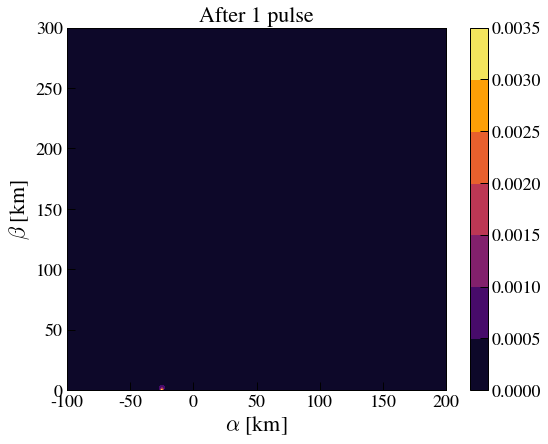

In [7]:
plot_posterior(1)

Notice the tiny little blip at the bottom! Our Bayesian inference is telling us that the most likely place for the ship is right at the shore, somewhere near $\alpha \approx -25\,\textrm{km}$. What's going on? We can get a clue by looking at what our first data point looks like:

In [8]:
print(x_i[0])

-24.904262960458283


Ah! So Bayes' theorem is telling us that with just one data point, our best guess for the location of the ship is right at the $\alpha$ location of the first data point, as close to the shore as possible. Why does that make sense? Consider the diagram below. Recall that the crew of the ship are emitting photons in randomly directions, uniformly over all angles. What we see below is that angles that are oriented directly at the shore do not "spread out" the probability of the photon locations as much. So if we see a photon at some location along the $x$ axis, a pretty good guess is to say that the ship is directly offshore from there.

<br>
<div>
<img src="equal_angles.png" width="400">
</div>


And why does it say we want to search close to the shore? It's because this dilution effect is more pronounced for ship closer to the shore than ships that are far away, so a very plausible explanation for why we're seeing a photon at $\alpha \approx -25 \,\textrm{km}$ is because there's ship right there! It's probably the first place to check.

<br>
<div>
<img src="distances.png" width="400">
</div>


Now let's see what happens when we receive a second pulse:

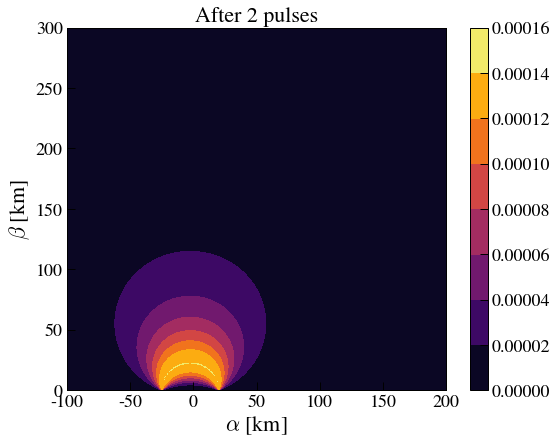

In [9]:
plot_posterior(2)

The second photon was clearly received at $\alpha \approx 20\,\textrm{km}$, so now our Bayesian inference is hedging a little. Let's go on and see what happens as we get more and more data

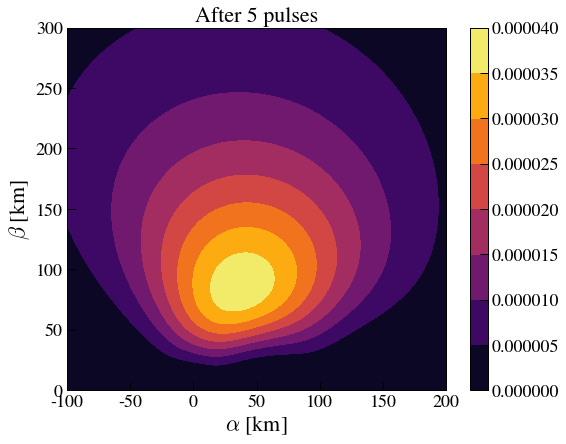

In [10]:
plot_posterior(5)

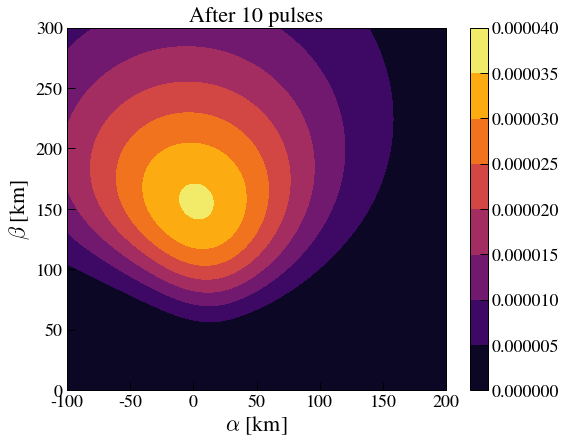

In [11]:
plot_posterior(10)

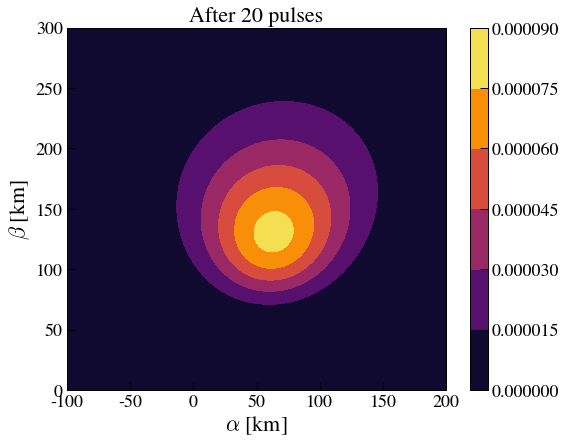

In [12]:
plot_posterior(20)

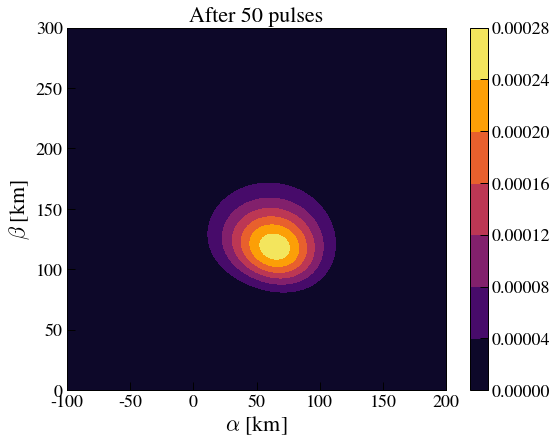

In [13]:
plot_posterior(50)

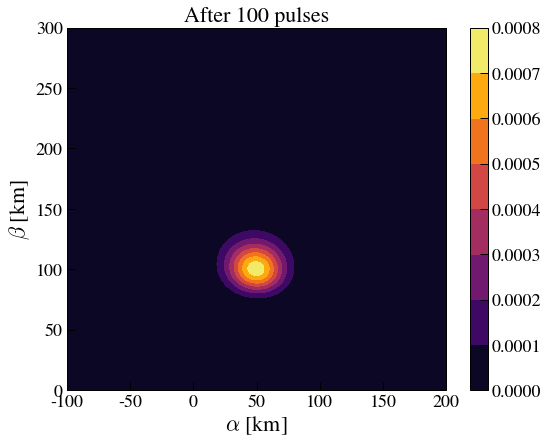

In [14]:
plot_posterior(100)

This is basically right! The values used in making the simulated data were $\alpha = 65\,\textrm{km}$ and $\beta = 120 \,\textrm{km}$. The peak of our posterior isn't right on that value, but we don't expect to---there are always uncertainties, and the true values lie within a plausible region in the posterior distribution

What if we don't care about how $\alpha$ is distributed? Maybe I only care about the probability distribution for $\beta$ because that's how far off the shore the ship is, and that will determine how much fuel I need to put into my rescue boat. If I don't care about $\alpha$, then I can __*marginalize*__ or integrate over it:

\begin{equation}
p(\beta| x_1, x_2, \dots, x_n) = \int p(\alpha, \beta| x_1, x_2, \dots, x_n) d\alpha
\end{equation}

In [15]:
beta_pdf = np.sum(posterior_collection, axis=2) * delta_alpha

In [25]:
def plot_marginalized(n):
    f, ax = plt.subplots(figsize=(6,4))
    ax.plot(betas, beta_pdf[n], color='red', lw=2)
    ax.plot(betas, beta_pdf[n-1], color='black', lw=2)
    ax.set_xlabel(r'$\beta$ [km]')
    ax.set_ylabel(r'$p(\beta| x_1, x_2, \dots, x_n)$')
    if n == 1:
        end_title = ' pulse'
    else:
        end_title = ' pulses'
    ax.set_title('After ' + str(n) + end_title)
    
def plot_both(n, save=False):
    f, ax = plt.subplots(1,2,figsize=(14,6), sharey=True)
    ax[0].contourf(alpha_grid, beta_grid, posterior_collection[n-1], cmap='inferno')
    ax[0].set_xlabel(r'$\alpha$ [km]')
    ax[0].set_ylabel(r'$\beta$ [km]')
    ax[0].set_ylim(0,300)
    ax[1].set_xlim(0,0.03)
    ax[1].plot(beta_pdf[n-1], betas, color='red', lw=2)
    ax[1].set_xlabel(r'$p(\beta| x_1, x_2, \dots, x_n)$')
    if n == 1:
        end_title = ' pulse'
    else:
        end_title = ' pulses'
    ax[1].set_title('After ' + str(n) + end_title)
    ax[0].set_title('After ' + str(n) + end_title)
    if save:
        plt.savefig('combo_' + str(n) + '.pdf')

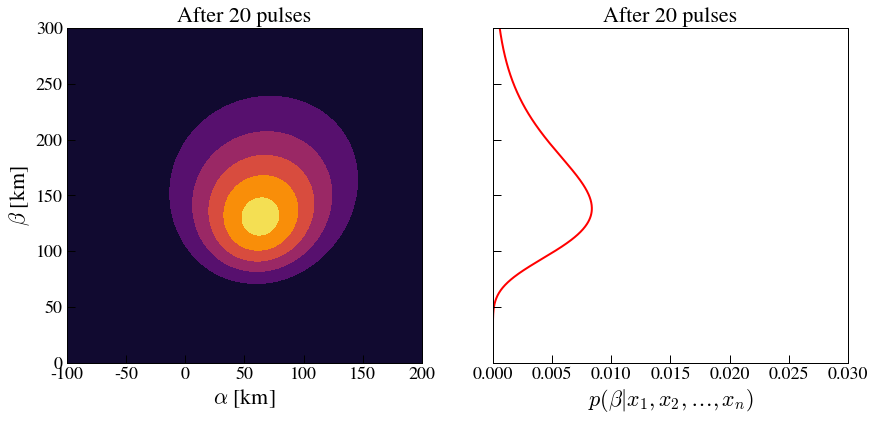

In [28]:
plot_both(20, save=True)

In [18]:
# To play as slideshow: 
# jupyter nbconvert Search\ and\ Rescue.ipynb --to slides --post serve --SlidesExporter.reveal_transition=none